In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
# from hurst import compute_Hc

In [2]:
!pip install hurst

In [3]:
 from hurst import compute_Hc

In [4]:
prices = pd.read_csv('final_data_norm.csv', parse_dates=['Timestamp'], index_col='Timestamp')
prices=prices.apply(lambda col:col.abs() if col.name !='Timestamp' else col)
prices


,Instr1,Instr2,Instr3,Instr4,Instr5,Instr6,Instr7,Instr8,Instr9,Instr10,Instr11,Instr12,Instr13,Instr14,Instr15,Instr16,Instr17,Instr18,Instr19,Instr20
Timestamp,,,,,,,,,,,,,,,,,,,,
2016-03-11,1.416659,1.420558,1.426727,1.426903,1.424853,1.421595,1.414042,1.403588,1.393133,1.382952,1.372094,1.360408,1.351622,1.343384,1.333519,1.325976,1.319087,1.313109,1.309208,1.306107
2016-03-14,1.462301,1.472009,1.482483,1.486425,1.485694,1.483600,1.477712,1.468183,1.459244,1.449825,1.439647,1.429297,1.421079,1.414141,1.405593,1.398603,1.393041,1.387593,1.384227,1.381651
2016-03-15,1.504228,1.514607,1.527892,1.535233,1.535472,1.533584,1.527089,1.517461,1.508316,1.499284,1.488712,1.477881,1.469107,1.461563,1.452365,1.444678,1.438367,1.432122,1.427919,1.425299
2016-03-16,1.419844,1.426643,1.440522,1.448331,1.447591,1.444372,1.437431,1.428227,1.419032,1.410119,1.399115,1.387963,1.378961,1.370482,1.361888,1.354871,1.348509,1.342255,1.338886,1.336325
2016-03-17,1.355626,1.360255,1.373846,1.382261,1.383064,1.381734,1.377009,1.370292,1.363145,1.355088,1.345784,1.335752,1.327977,1.320802,1.312817,1.306453,1.301592,1.296917,1.294369,1.292677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,0.835726,0.779651,0.811547,0.839093,0.864957,0.887792,0.908630,0.926472,0.941884,0.955530,0.966677,0.975294,0.981823,0.989337,0.998928,1.007441,1.015631,1.022611,1.028738,1.034918
2023-12-01,0.626091,0.664025,0.698311,0.730168,0.758640,0.782129,0.802080,0.818593,0.833516,0.846164,0.856458,0.865071,0.871727,0.881696,0.890817,0.898892,0.907484,0.914124,0.920744,0.929995
2023-12-04,0.580980,0.625299,0.666123,0.703383,0.737745,0.766944,0.791685,0.813265,0.831472,0.846861,0.859302,0.869422,0.879116,0.890729,0.900785,0.910606,0.919412,0.927077,0.934759,0.945104


In [5]:
cumret = np.log(prices).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True)

In [6]:
def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]

    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint

    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]

    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant

    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]

    return halflife

def calculate_metrics(pairs, cumret, pairs_df):
    '''
    calculate metrics for pairs using data in cumret
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller

    cols = ['Euclidean distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 'Pearson r',
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within historical 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread = cumret[s1] - cumret[s2]
        results.loc[pair]['Euclidean distance'] = np.sqrt(np.sum((spread)**2))
        results.loc[pair]['CADF p-value'] = cadf_pvalue(s1, s2, cumret)
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        hist_sd = pairs_df.loc[pair]['Spread SD'] # historical standard deviation
        results.loc[pair]['Spread SD'] = hist_sd
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0][1]
        results.loc[pair]['Num zero-crossings'] = ((spread[1:].values * spread[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within historical 2-SD band'] = (abs(spread) < 2*hist_sd).sum() / len(spread) * 100

    return results

def plot_pairs(pairs, cumret_train, cumret_test):
    '''
    plot cumulative returns of the spread for each pair in pairs
    '''

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        spread_train = cumret_train[s1] - cumret_train[s2]
        spread_test = cumret_test[s1] - cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

In [7]:
def select_pairs(train):
    '''
    select pairs using data from train dataframe
    return dataframe of selected pairs
    '''
    tested = []

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller

    cols = ['Euclidean distance', 'Num zero-crossings', 'Pearson r',
            'Spread SD', 'Hurst Exponent', 'Half-life of mean reversion']
    pairs = pd.DataFrame(columns=cols)

    for s1 in train.columns:
        for s2 in train.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested) and (f'{s2}-{s1}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = cadf_pvalue(s1,s2,train)
                if cadf_p<0.01:
                    spread = train[s1] - train[s2]
                    hurst = compute_Hc(spread)[0]
                    if hurst<0.5:
                        halflife = calculate_halflife(spread)
                        if halflife>1 and halflife<30:
                            num_crossings = (spread.values[1:] * spread.values[:-1] < 0).sum()
                            if num_crossings>len(train.index)/252*12:
                                distance = np.sqrt(np.sum((train[s1] - train[s2])**2)) # Euclidean distance
                                pearson_r = np.corrcoef(train[s1], train[s2])[0][1]
                                spread_sd = spread.std()
                                pairs.loc[f'{s1}-{s2}'] = [distance, num_crossings, pearson_r,
                                                           spread_sd, hurst, halflife]

    return pairs


In [8]:
cumret12_6 = cumret.loc['2017-11-30':]
cumret12_6 = cumret12_6 / cumret12_6.iloc[0] # divide by first row so that all prices start at 1
train12_6 = cumret12_6.loc['2017-12-12':'2018-09-12'] # formation period
test12_6 = cumret12_6.loc['2018-11-05':'2023-12-06'] # trading period
test12_6

,Instr1,Instr2,Instr3,Instr4,Instr5,Instr6,Instr7,Instr8,Instr9,Instr10,Instr11,Instr12,Instr13,Instr14,Instr15,Instr16,Instr17,Instr18,Instr19,Instr20
Timestamp,,,,,,,,,,,,,,,,,,,,
2018-11-05,0.465263,0.484400,0.395033,0.312752,0.231190,0.160375,0.092398,0.026573,-0.041979,-0.112828,-0.196554,-0.283179,-0.372053,-0.463130,-0.584951,-0.696873,-0.832481,-1.005208,-1.101624,-1.272742
2018-11-06,0.647537,0.679037,0.572919,0.477404,0.382851,0.300158,0.226510,0.160785,0.094349,0.026905,-0.052175,-0.131992,-0.223004,-0.317330,-0.435616,-0.547623,-0.685806,-0.864603,-0.974439,-1.161086
2018-11-07,0.659172,0.685794,0.575092,0.466750,0.357750,0.260817,0.174249,0.095429,0.015745,-0.067424,-0.167969,-0.274562,-0.393963,-0.519931,-0.684034,-0.843248,-1.041513,-1.300782,-1.471313,-1.755328
2018-11-08,0.985182,1.001391,0.848602,0.710980,0.580189,0.464864,0.369505,0.290655,0.219600,0.147994,0.067724,-0.015561,-0.113723,-0.222866,-0.359998,-0.500574,-0.671733,-0.891022,-1.046805,-1.291091
2018-11-09,1.122637,1.160939,0.991637,0.845490,0.708089,0.588234,0.496983,0.427071,0.371591,0.321991,0.265322,0.211991,0.135983,0.049640,-0.063170,-0.178744,-0.315681,-0.492348,-0.623046,-0.815727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29,-0.475956,-0.646834,-0.714333,-0.789633,-0.861748,-0.930698,-1.009684,-1.117523,-1.248243,-1.399208,-1.577264,-1.791263,-1.996785,-2.178376,-2.450948,-2.691377,-3.009315,-3.449262,-3.667050,-4.119168
2023-11-30,-0.459417,-0.484576,-0.547806,-0.614901,-0.680404,-0.741399,-0.813753,-0.909528,-1.024007,-1.155523,-1.311842,-1.497589,-1.674364,-1.833942,-2.075240,-2.287932,-2.569731,-2.954552,-3.148857,-3.545425
2023-12-01,-0.178456,-0.290128,-0.358907,-0.432621,-0.502236,-0.563872,-0.631767,-0.716922,-0.818340,-0.932678,-1.067432,-1.228403,-1.381662,-1.529590,-1.740963,-1.928286,-2.177993,-2.512731,-2.688688,-3.051470


In [10]:
pairs12_6 = select_pairs(train12_6)
pairs12_6

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
Instr1-Instr2,4.494464,19.0,0.984651,0.285697,0.363097,2.446813
Instr1-Instr3,5.875288,13.0,0.965859,0.395618,0.301044,1.841904
Instr1-Instr4,8.014761,13.0,0.941214,0.551071,0.390499,1.601080
Instr1-Instr5,9.396040,13.0,0.929656,0.649770,0.325194,1.640591
Instr1-Instr6,11.308306,11.0,0.909152,0.786190,0.300660,1.634668
...,...,...,...,...,...,...
Instr16-Instr18,33.705891,19.0,0.921460,2.336938,0.328888,1.027298
Instr16-Instr19,38.139000,27.0,0.892715,2.640472,0.270949,1.219431
Instr16-Instr20,48.162051,29.0,0.853769,3.327649,0.229915,1.324890
Instr17-Instr19,31.808208,25.0,0.917225,2.233222,0.311024,1.063191


In [11]:
pairs12_6.sort_values(by='Euclidean distance')

,Euclidean distance,Num zero-crossings,Pearson r,Spread SD,Hurst Exponent,Half-life of mean reversion
Instr2-Instr3,1.878699,14.0,0.995031,0.135212,0.313026,1.003212
Instr2-Instr4,4.408986,17.0,0.978299,0.316800,0.358549,1.039296
Instr1-Instr2,4.494464,19.0,0.984651,0.285697,0.363097,2.446813
Instr1-Instr3,5.875288,13.0,0.965859,0.395618,0.301044,1.841904
Instr13-Instr14,6.348287,26.0,0.992920,0.438447,0.325133,2.011128
...,...,...,...,...,...,...
Instr7-Instr20,76.731675,21.0,0.513411,5.173339,0.328577,3.119854
Instr6-Instr20,77.454763,23.0,0.519417,5.211183,0.306689,3.256028
Instr5-Instr20,78.104243,21.0,0.513806,5.252373,0.288902,3.291213
Instr2-Instr20,79.879672,15.0,0.480633,5.375444,0.289422,3.605848


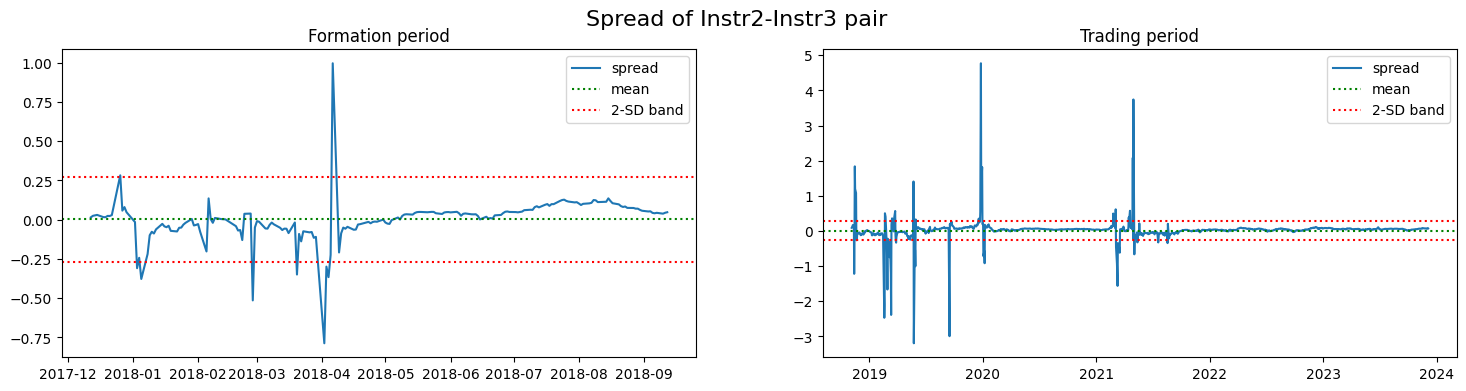

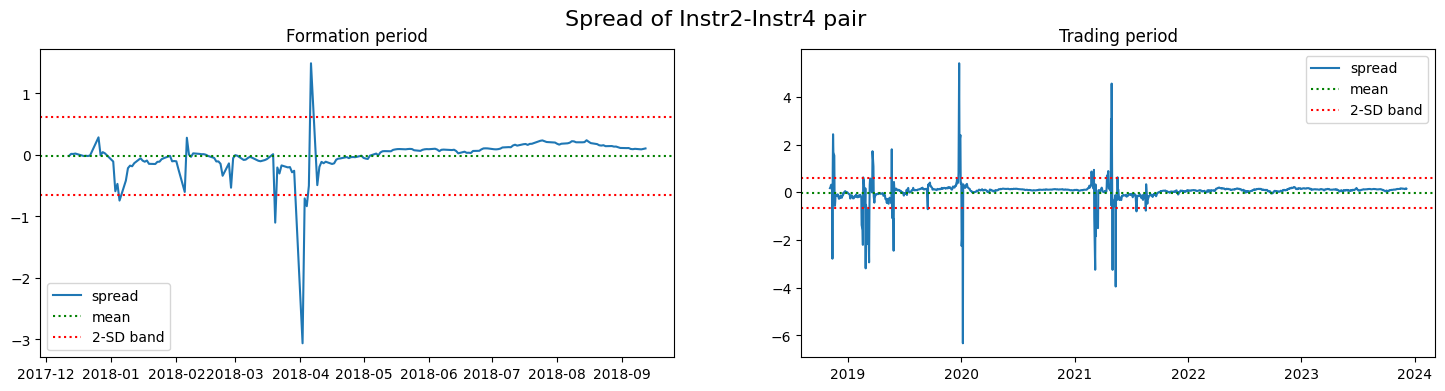

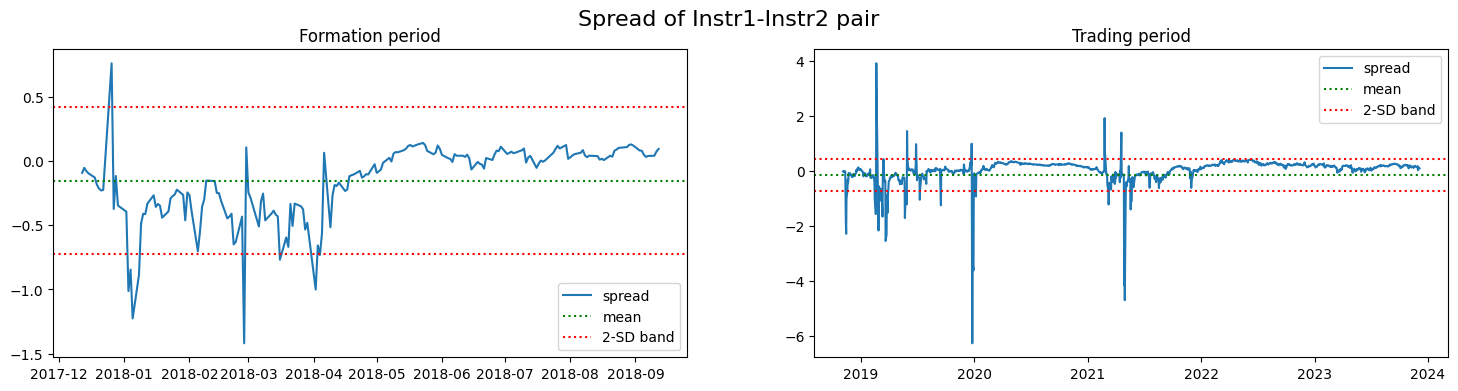

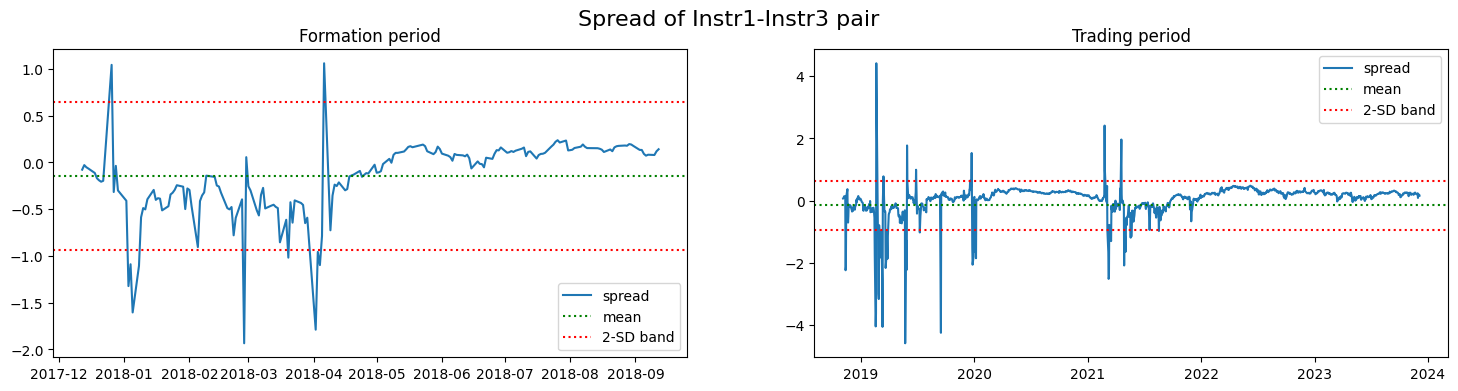

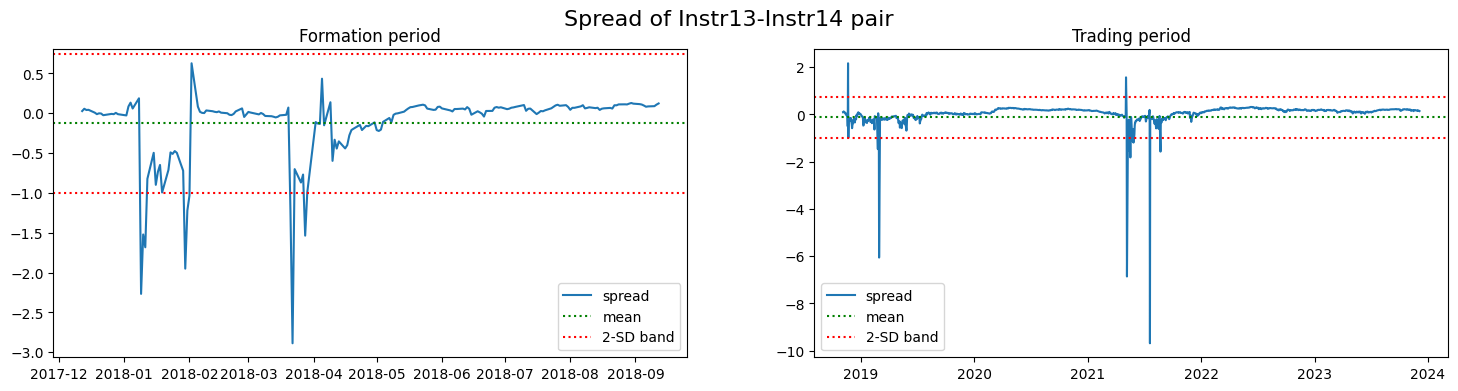

In [12]:
top5_distance = list(pairs12_6.sort_values(by='Euclidean distance').index[:5])
plot_pairs(top5_distance, train12_6, test12_6)
